# Restricted Boltzmann Machine features for digit classification

Adapted from http://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html

For greyscale image data where pixel values can be interpreted as degrees of blackness on a white background, like handwritten digit recognition, the Bernoulli Restricted Boltzmann machine model (BernoulliRBM) can perform effective non-linear feature extraction.

In order to learn good latent representations from a small dataset, we artificially generate more labeled data by perturbing the training data with linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a BernoulliRBM feature extractor and a LogisticRegression classifier. The hyperparameters of the entire model (learning rate, hidden layer size, regularization) were optimized by grid search, but the search is not reproduced here because of runtime constraints.

Logistic regression on raw pixel values is presented for comparison. The example shows that the features extracted by the BernoulliRBM help improve the classification accuracy.

In [2]:
include("preamble.jl")

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:38
 in find_in_path at /Users/cedric/.julia/v0.4/Autoreload/src/files.jl:11
 in find_file at /Users/cedric/.julia/v0.4/Autoreload/src/files.jl:40
 in arequire at /Users/cedric/.julia/v0.4/Autoreload/src/Autoreload.jl:50
 in include at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/cedric/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/cedric/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /Users/cedric/Programa/Sklearn/notebooks/preamble.jl, in expression starting on line 4


In [3]:
@pyimport2 scipy.ndimage: convolve
@pyimport2 sklearn: (linear_model, datasets, metrics)
@pyimport2 sklearn.cross_validation: train_test_split
@pyimport2 sklearn.neural_network: BernoulliRBM

 in depwarn at deprecated.jl:73
 [inlined code] from deprecated.jl:694
 in require at no file:0
 in arequire at /Users/cedric/.julia/v0.4/Autoreload/src/Autoreload.jl:87
 in include at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/cedric/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/cedric/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /Users/cedric/Programa/Sklearn/notebooks/preamble.jl, in expression starting on line 4


PyObject <class 'sklearn.neural_network.rbm.BernoulliRBM'>

In [4]:
using Sklearn: Pipeline

In [5]:
###############################################################################
# Setting up

    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
function nudge_dataset(X, Y)
    direction_vectors = Any[
        [0 1 0
         0 0 0
         0 0 0],
        [0 0 0
         1 0 0
         0 0 0],

        [0 0 0
         0 0 1
         0 0 0],

        [0 0 0
         0 0 0
         0 1 0]]

    shift(x, w) = convolve(reshape(x, 8, 8); mode="constant", weights=w)[:]
    X = vcat(X, Any[vcat([shift(X[i, :], vector)' for i in 1:size(X, 1)]...)
                 for vector in direction_vectors]...)
    Y = vcat(fill(Y, 5)...)
    return X, Y
end

# Load Data
digits = datasets.load_digits()
X = digits["data"]
X, Y = nudge_dataset(X, digits["target"]);

X = (X .- minimum(X, 1)) ./ (maximum(X, 1) .+ 0.0001);

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0);

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=true)

PyObject BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=256, n_iter=10,
       random_state=0, verbose=True)

In [7]:
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])

Sklearn.Pipeline(false,[("rbm",PyObject BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=256, n_iter=10,
       random_state=0, verbose=True)),("logistic",PyObject LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

In [46]:
###############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm[:learning_rate] = 0.06
rbm[:n_iter] = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm[:n_components] = 100
logistic[:C] = 6000.0

# Training RBM-Logistic Pipeline
fit!(classifier, X_train, Y_train)

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)
fit!(logistic_classifier, X_train, Y_train);

6000.0

Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.99      0.98      0.99       174
          1       0.94      0.95      0.95       184
          2       0.95      0.97      0.96       166
          3       0.95      0.88      0.91       194
          4       0.96      0.97      0.97       186
          5       0.92      0.92      0.92       181
          6       0.99      0.97      0.98       207
          7       0.94      0.97      0.96       154
          8       0.88      0.88      0.88       182
          9       0.90      0.93      0.91       169

avg / total       0.94      0.94      0.94      1797



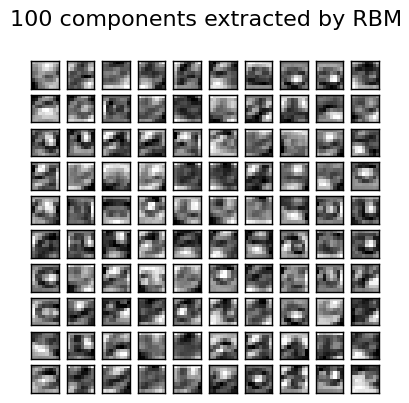

Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.86      0.94      0.90       174
          1       0.55      0.53      0.54       184
          2       0.79      0.86      0.82       166
          3       0.78      0.73      0.75       194
          4       0.86      0.83      0.85       186
          5       0.79      0.77      0.78       181
          6       0.89      0.89      0.89       207
          7       0.85      0.93      0.89       154
          8       0.65      0.60      0.63       182
          9       0.71      0.72      0.72       169

avg / total       0.77      0.78      0.78      1797



In [62]:
###############################################################################
# Evaluation

report = metrics.classification_report(Y_test, predict(classifier, X_test))
println("Logistic regression using RBM features:\n$(report)")
report2 = metrics.classification_report(Y_test, predict(logistic_classifier, X_test))
print("Logistic regression using raw pixel features:\n$(report2)\n")

###############################################################################
# Plotting

figure(figsize=(4.2, 4))
for i in 1:size(rbm[:components_], 1)
    comp = rbm[:components_][i, :]
    subplot(10, 10, i)
    imshow(reshape(comp, 8, 8), cmap=get_cmap("gray_r"),
           interpolation="nearest")
    xticks(())
    yticks(())
end

suptitle("100 components extracted by RBM", fontsize=16)
subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)